# KDD Data Analysis and Attack Classification using Machine Learning & Neural Networks
This notebook covers data preprocessing, feature engineering, and training multiple ML models to classify attacks using the KDD dataset.

In [2]:

import pandas as pd  # Importing pandas for data handling
import numpy as np  # Importing numpy for numerical operations
import seaborn as sns  # Importing seaborn for visualization
import matplotlib.pyplot as plt  # Importing matplotlib for plotting graphs
from sklearn.model_selection import train_test_split  # Splitting dataset into train and test
from sklearn.preprocessing import StandardScaler, LabelEncoder  # Encoding categorical variables and scaling data
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Importing classification models
from sklearn.svm import SVC  # Importing Support Vector Classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Evaluation metrics
import tensorflow as tf  # TensorFlow for deep learning
from tensorflow import keras  # Keras API for building models
from tensorflow.keras.models import Sequential  # Sequential model type
from tensorflow.keras.layers import Dense, Dropout  # Neural network layers


## Load the KDD dataset from URL

In [4]:

# Load KDD dataset from URL
url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
             "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
             "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
             "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
             "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
             "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

df = pd.read_csv(url, names=col_names, compression='gzip')

df.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [5]:
# prompt: sample 5000 rows to make training faster

# Sample 5000 rows from the DataFrame
df = df.sample(n=5000, random_state=42)  # Use random_state for reproducibility

# Now df_sampled contains your sampled data
df.shape


(5000, 42)

## Data Preprocessing & Feature Engineering

In [7]:

# Encoding categorical variables into numeric form
encoder = LabelEncoder()
categorical_columns = ['protocol_type', 'service', 'flag']
for col in categorical_columns:
    df[col] = encoder.fit_transform(df[col])

# Convert labels into binary classification (attack or normal)
df['label'] = df['label'].apply(lambda x: 'normal' if x == 'normal.' else 'attack')
df['label'] = encoder.fit_transform(df['label'])

# Feature Engineering: Creating new features
df['byte_ratio'] = df['src_bytes'] / (df['dst_bytes'] + 1)
df['total_count'] = df['count'] + df['srv_count']
df['error_rate'] = (df['serror_rate'] + df['rerror_rate']) / 2

df.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,byte_ratio,total_count,error_rate
317921,0,0,13,6,1032,0,0,0,0,0,...,1.00,0.00,0.0,0.0,0.0,0.0,0,1032.000000,1022,0.0
171422,0,0,13,6,1032,0,0,0,0,0,...,1.00,0.00,0.0,0.0,0.0,0.0,0,1032.000000,1022,0.0
312181,0,0,13,6,1032,0,0,0,0,0,...,1.00,0.00,0.0,0.0,0.0,0.0,0,1032.000000,1022,0.0
87346,0,1,18,6,345,5419,0,0,0,0,...,0.01,0.02,0.0,0.0,0.0,0.0,1,0.063653,12,0.0
57449,0,1,31,3,0,0,0,0,0,0,...,0.00,0.00,1.0,1.0,0.0,0.0,0,0.000000,262,0.5


## Splitting Data into Training and Testing Sets

In [9]:

X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Training Machine Learning Models
Random Forest Classifiers:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Gradient Boosting Classifier:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

Support Vector Classifier:
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#

In [11]:

# RandomForest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Gradient Boosting Classifier
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

# Support Vector Machine (SVM)
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


Random Forest Accuracy: 0.997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       808
           1       0.98      1.00      0.99       192

    accuracy                           1.00      1000
   macro avg       0.99      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Gradient Boosting Accuracy: 0.997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       808
           1       0.98      1.00      0.99       192

    accuracy                           1.00      1000
   macro avg       0.99      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

SVM Accuracy: 0.994
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       808
           1       0.98      0.98      0.98       192

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99 

## Building a Neural Network Classifier

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [14]:

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


C:\Users\agyem\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8233 - loss: 0.4225 - val_accuracy: 0.9880 - val_loss: 0.0539
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9768 - loss: 0.0932 - val_accuracy: 0.9930 - val_loss: 0.0437
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9887 - loss: 0.0487 - val_accuracy: 0.9940 - val_loss: 0.0410
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9918 - loss: 0.0408 - val_accuracy: 0.9950 - val_loss: 0.0431
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9921 - loss: 0.0419 - val_accuracy: 0.9950 - val_loss: 0.0461
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9932 - loss: 0.0356 - val_accuracy: 0.9950 - val_loss: 0.0509
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9934 - loss: 0.0256 - val_accuracy: 0.9950 - val_loss: 0.0516
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9959 - loss: 0.0246 - val_accuracy: 0.

## Evaluating Neural Network Performance

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Neural Network Accuracy: 0.997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       808
           1       0.99      0.99      0.99       192

    accuracy                           1.00      1000
   macro avg       0.99      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



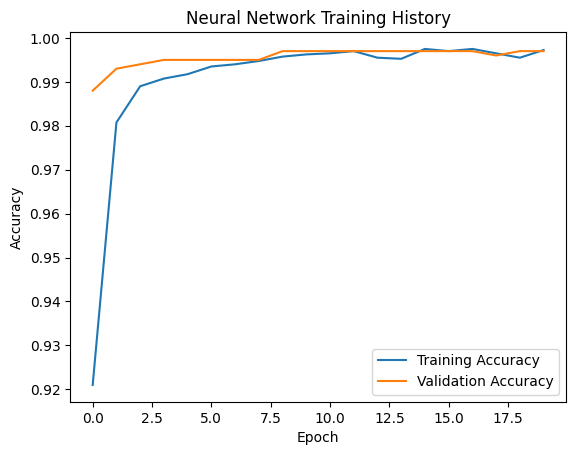

In [16]:

y_pred_nn = (model.predict(X_test) > 0.5).astype("int32")
print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Neural Network Training History')
plt.show()


Based on the above code, write your own code to develop other ML or Neural network algorithms from list below.

Machine Learning Algorithms
**bold text**
Decision Tree Classifier:  https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

K-Nearest Neighbors (KNN):  https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

Logistic Regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Naive Bayes Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html


**Deep Learning Models**
Long Short-Term Memory (LSTM): https://keras.io/api/layers/recurrent_layers/lstm/

Convolutional Neural Networks (CNN): https://keras.io/api/layers/convolution_layers/convolution1d/

Transformers (Hugging Face Transformers)

**Important: Lab-Logbbok requirement**

Provide a bar graph comparing accuracy, precicion, recall, and f-score for various AI models



In [19]:
# Additional Machine Learning Models for Attack Classification

# 1. Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
dt_report = classification_report(y_test, y_pred_dt, output_dict=True)
print(classification_report(y_test, y_pred_dt))

# 2. K-Nearest Neighbors (KNN)
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
knn_report = classification_report(y_test, y_pred_knn, output_dict=True)
print(classification_report(y_test, y_pred_knn))

# 3. Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
lr_report = classification_report(y_test, y_pred_lr, output_dict=True)
print(classification_report(y_test, y_pred_lr))

# 4. Naive Bayes
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
nb_report = classification_report(y_test, y_pred_nb, output_dict=True)
print(classification_report(y_test, y_pred_nb))

Decision Tree Accuracy: 0.996
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       808
           1       0.98      1.00      0.99       192

    accuracy                           1.00      1000
   macro avg       0.99      1.00      0.99      1000
weighted avg       1.00      1.00      1.00      1000

KNN Accuracy: 0.994
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       808
           1       0.97      0.99      0.98       192

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

Logistic Regression Accuracy: 0.993
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       808
           1       0.98      0.98      0.98       192

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.9

In [20]:
# Additional Deep Learning Models for Attack Classification

# 1. LSTM Network
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Conv1D, MaxPooling1D, Flatten
import tensorflow as tf

# Reshape data for LSTM (samples, time steps, features)
# Since this isn't sequential data, we'll create a sequence window of 1
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build LSTM model
lstm_model = Sequential([
    LSTM(64, input_shape=(1, X_train.shape[1]), return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_history = lstm_model.fit(X_train_reshaped, y_train, 
                             epochs=5,  # Reduced for demonstration
                             batch_size=64,
                             validation_data=(X_test_reshaped, y_test),
                             verbose=1)

y_pred_lstm = (lstm_model.predict(X_test_reshaped) > 0.5).astype("int32")
print("LSTM Accuracy:", accuracy_score(y_test, y_pred_lstm))
lstm_report = classification_report(y_test, y_pred_lstm, output_dict=True)
print(classification_report(y_test, y_pred_lstm))

# 2. CNN (1D)
# Reshape data for CNN
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build CNN model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(X_train_cnn, y_train,
                           epochs=5,  # Reduced for demonstration
                           batch_size=64,
                           validation_data=(X_test_cnn, y_test),
                           verbose=1)

y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype("int32")
print("CNN Accuracy:", accuracy_score(y_test, y_pred_cnn))
cnn_report = classification_report(y_test, y_pred_cnn, output_dict=True)
print(classification_report(y_test, y_pred_cnn))

C:\Users\agyem\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7985 - loss: 0.6457 - val_accuracy: 0.9910 - val_loss: 0.2563
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9905 - loss: 0.1532 - val_accuracy: 0.9940 - val_loss: 0.0223
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9951 - loss: 0.0247 - val_accuracy: 0.9950 - val_loss: 0.0168
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9978 - loss: 0.0135 - val_accuracy: 0.9950 - val_loss: 0.0161
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9983 - loss: 0.0105 - val_accuracy: 0.9950 - val_loss: 0.0159
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
LSTM Accuracy: 0.995
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       808
           1       0.98      0.99      0.99       192

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       1.00      0.99      1.

C:\Users\agyem\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9087 - loss: 0.3437 - val_accuracy: 0.9950 - val_loss: 0.0407
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9932 - loss: 0.0315 - val_accuracy: 0.9960 - val_loss: 0.0570
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9951 - loss: 0.0212 - val_accuracy: 0.9950 - val_loss: 0.0550
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9943 - loss: 0.0205 - val_accuracy: 0.9940 - val_loss: 0.0501
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9979 - loss: 0.0111 - val_accuracy: 0.9930 - val_loss: 0.0622
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
CNN Accuracy: 0.993
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       808
           1       0.98      0.98      0.98       192

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

                     Accuracy  Precision    Recall  F1-score
Random Forest           0.997   0.984615  1.000000  0.992248
Gradient Boosting       0.997   0.984615  1.000000  0.992248
SVM                     0.994   0.984375  0.984375  0.984375
Neural Network          0.997   0.989637  0.994792  0.992208
Decision Tree           0.996   0.979592  1.000000  0.989691
KNN                     0.994   0.974490  0.994792  0.984536
Logistic Regression     0.993   0.984293  0.979167  0.981723
Naive Bayes             0.990   0.973958  0.973958  0.973958
LSTM                    0.995   0.979487  0.994792  0.987080
CNN                     0.993   0.979275  0.984375  0.981818


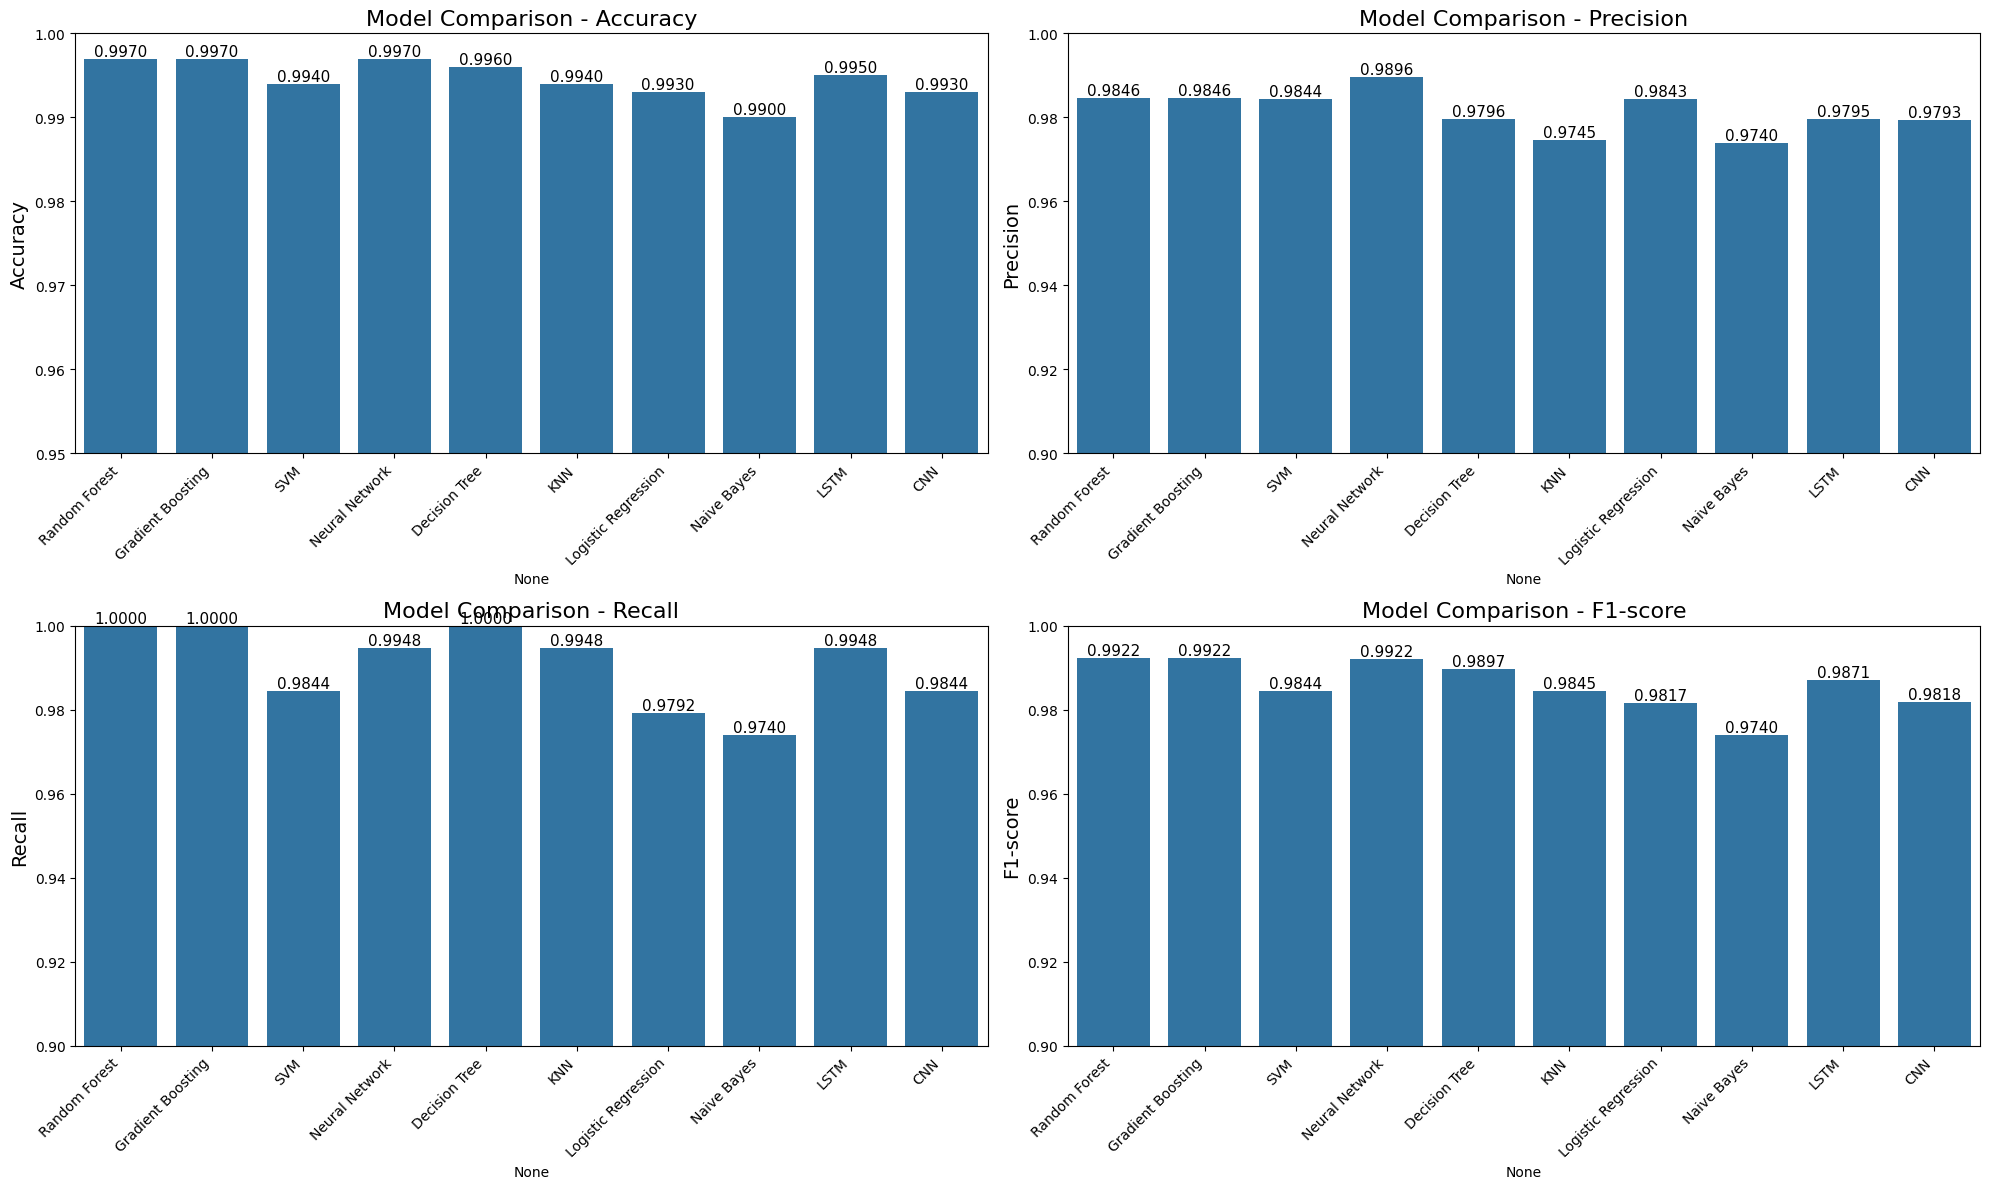

In [28]:
# Model Comparison Visualization - Accuracy, Precision, Recall, and F1-Score

# Store results
import pandas as pd

# Get metrics from classification reports
model_names = ['Random Forest', 'Gradient Boosting', 'SVM', 'Neural Network', 
               'Decision Tree', 'KNN', 'Logistic Regression', 'Naive Bayes', 
               'LSTM', 'CNN']

# Get the existing model reports
rf_report = classification_report(y_test, y_pred_rf, output_dict=True)
gb_report = classification_report(y_test, y_pred_gb, output_dict=True)
svm_report = classification_report(y_test, y_pred_svm, output_dict=True)
nn_report = classification_report(y_test, y_pred_nn, output_dict=True)

# Function to extract metrics
def extract_metrics(report, label=1):  # Label 1 is the attack class
    return {
        'Accuracy': report['accuracy'],
        'Precision': report[str(label)]['precision'],
        'Recall': report[str(label)]['recall'],
        'F1-score': report[str(label)]['f1-score']
    }

# Extract metrics for each model
metrics_list = [
    extract_metrics(rf_report),
    extract_metrics(gb_report),
    extract_metrics(svm_report),
    extract_metrics(nn_report),
    extract_metrics(dt_report),
    extract_metrics(knn_report),
    extract_metrics(lr_report),
    extract_metrics(nb_report),
    extract_metrics(lstm_report),
    extract_metrics(cnn_report)
]

# Create a DataFrame with all metrics
df_metrics = pd.DataFrame(metrics_list, index=model_names)
print(df_metrics)

# Visualization of metrics
plt.figure(figsize=(20, 12))

# Plot each metric as a subplot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    ax = sns.barplot(x=df_metrics.index, y=df_metrics[metric])
    plt.title(f'Model Comparison - {metric}', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(metric, fontsize=14)
    # Add value labels on top of each bar
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.4f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', 
                    fontsize=11)
    
    # Set y-axis limits to better visualize the differences
    if metric == 'Accuracy':
        plt.ylim(0.95, 1.0)  # Adjust based on your results
    else:
        plt.ylim(0.9, 1.0)   # Adjust based on your results

plt.tight_layout()
plt.savefig('model_comparison.png')  # Save the figure
plt.show()

In [30]:
# Model Comparison - Setup Data Frame with Metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get metrics from classification reports
model_names = ['Random Forest', 'Gradient Boosting', 'SVM', 'Neural Network', 
               'Decision Tree', 'KNN', 'Logistic Regression', 'Naive Bayes', 
               'LSTM', 'CNN']

# Function to extract metrics
def extract_metrics(report, label=1):  # Label 1 is the attack class
    return {
        'Accuracy': report['accuracy'],
        'Precision': report[str(label)]['precision'],
        'Recall': report[str(label)]['recall'],
        'F1-score': report[str(label)]['f1-score']
    }

# Extract metrics for each model
metrics_list = [
    extract_metrics(rf_report),
    extract_metrics(gb_report),
    extract_metrics(svm_report),
    extract_metrics(nn_report),
    extract_metrics(dt_report),
    extract_metrics(knn_report),
    extract_metrics(lr_report),
    extract_metrics(nb_report),
    extract_metrics(lstm_report),
    extract_metrics(cnn_report)
]

# Create a DataFrame with all metrics
df_metrics = pd.DataFrame(metrics_list, index=model_names)
print(df_metrics)

                     Accuracy  Precision    Recall  F1-score
Random Forest           0.997   0.984615  1.000000  0.992248
Gradient Boosting       0.997   0.984615  1.000000  0.992248
SVM                     0.994   0.984375  0.984375  0.984375
Neural Network          0.997   0.989637  0.994792  0.992208
Decision Tree           0.996   0.979592  1.000000  0.989691
KNN                     0.994   0.974490  0.994792  0.984536
Logistic Regression     0.993   0.984293  0.979167  0.981723
Naive Bayes             0.990   0.973958  0.973958  0.973958
LSTM                    0.995   0.979487  0.994792  0.987080
CNN                     0.993   0.979275  0.984375  0.981818


C:\Users\agyem\AppData\Local\Temp\ipykernel_10212\416922658.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_metrics.index, y=df_metrics['Accuracy'], palette=colors)
C:\Users\agyem\AppData\Local\Temp\ipykernel_10212\416922658.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


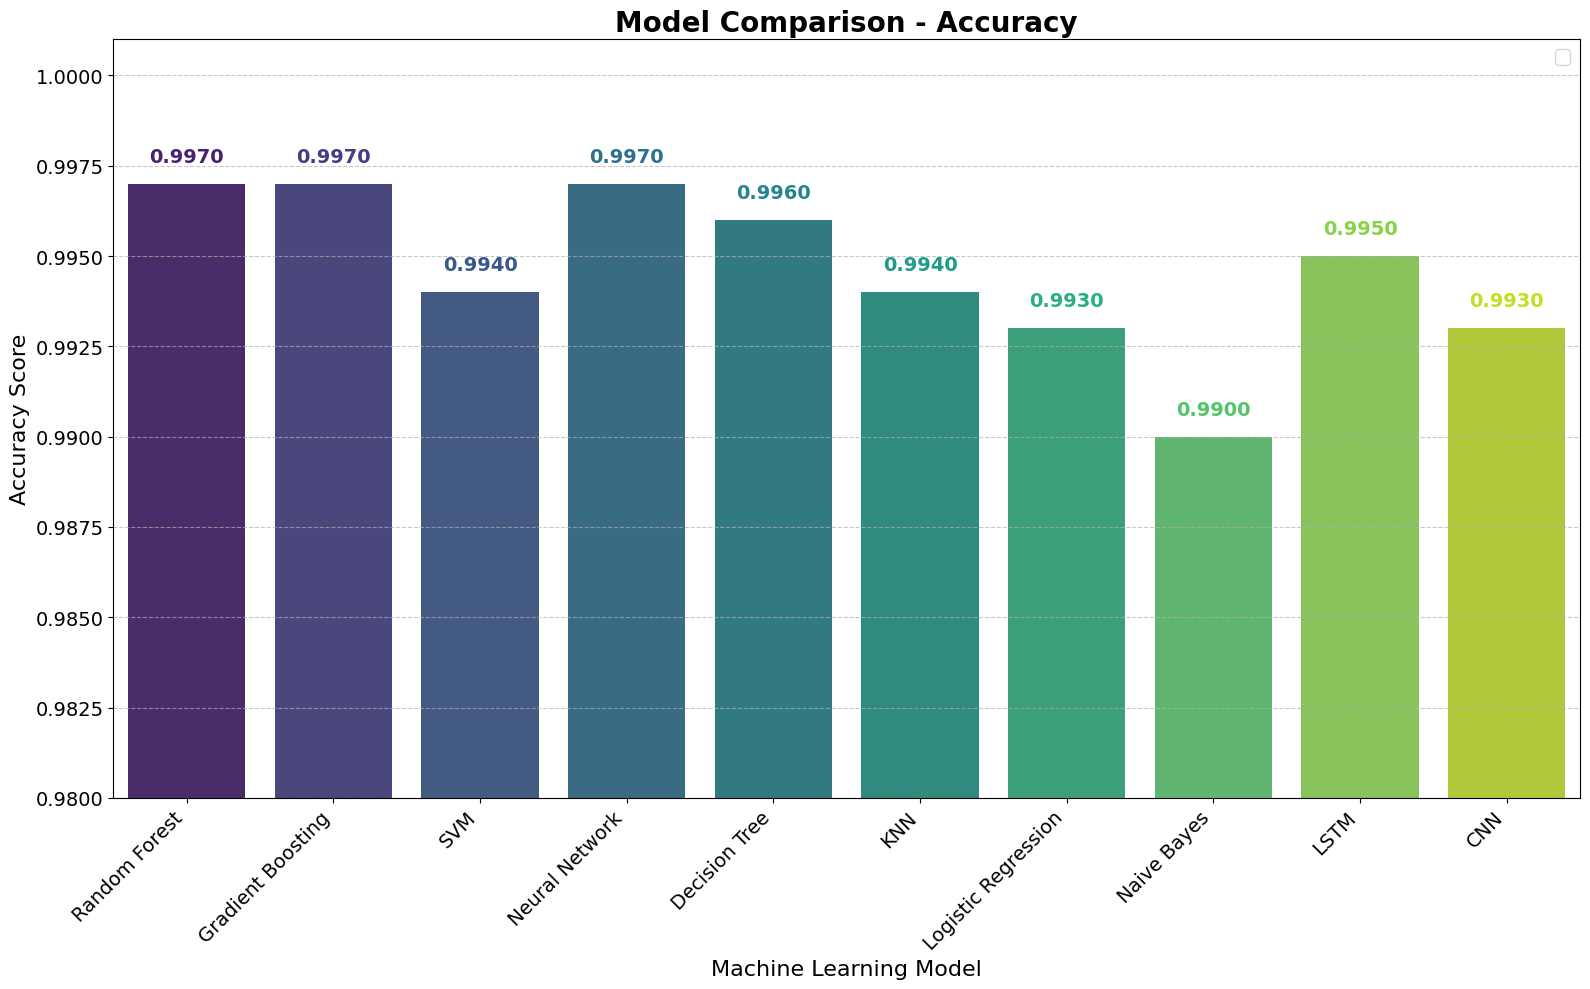

In [34]:
# Accuracy Comparison Visualization
plt.figure(figsize=(16, 10))

# Set a color palette for consistency
colors = sns.color_palette("viridis", len(model_names))

# Plot with enhanced styling
ax = sns.barplot(x=df_metrics.index, y=df_metrics['Accuracy'], palette=colors)

# Customize the plot
plt.title('Model Comparison - Accuracy', fontsize=20, fontweight='bold')
plt.xlabel('Machine Learning Model', fontsize=16)
plt.ylabel('Accuracy Score', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set y-axis limits to better visualize the differences
plt.ylim(df_metrics['Accuracy'].min() - 0.01, 1.001)  # Dynamic adjustment with padding

# Add value labels on top of each bar
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(f"{height:.4f}", 
                (p.get_x() + p.get_width() / 2., height + 0.0005), 
                ha='center', va='bottom', 
                fontsize=14, fontweight='bold',
                color=colors[i])
    
# Add a horizontal line at the average accuracy
avg_accuracy = df_metrics['Accuracy'].mean()
# plt.axhline(y=avg_accuracy, color='r', linestyle='--', alpha=0.7, 
#             label=f'Average Accuracy: {avg_accuracy:.4f}')
plt.legend(fontsize=14)

plt.tight_layout()
plt.savefig('accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\agyem\AppData\Local\Temp\ipykernel_10212\4105600850.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_metrics.index, y=df_metrics['Precision'], palette=colors)
C:\Users\agyem\AppData\Local\Temp\ipykernel_10212\4105600850.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


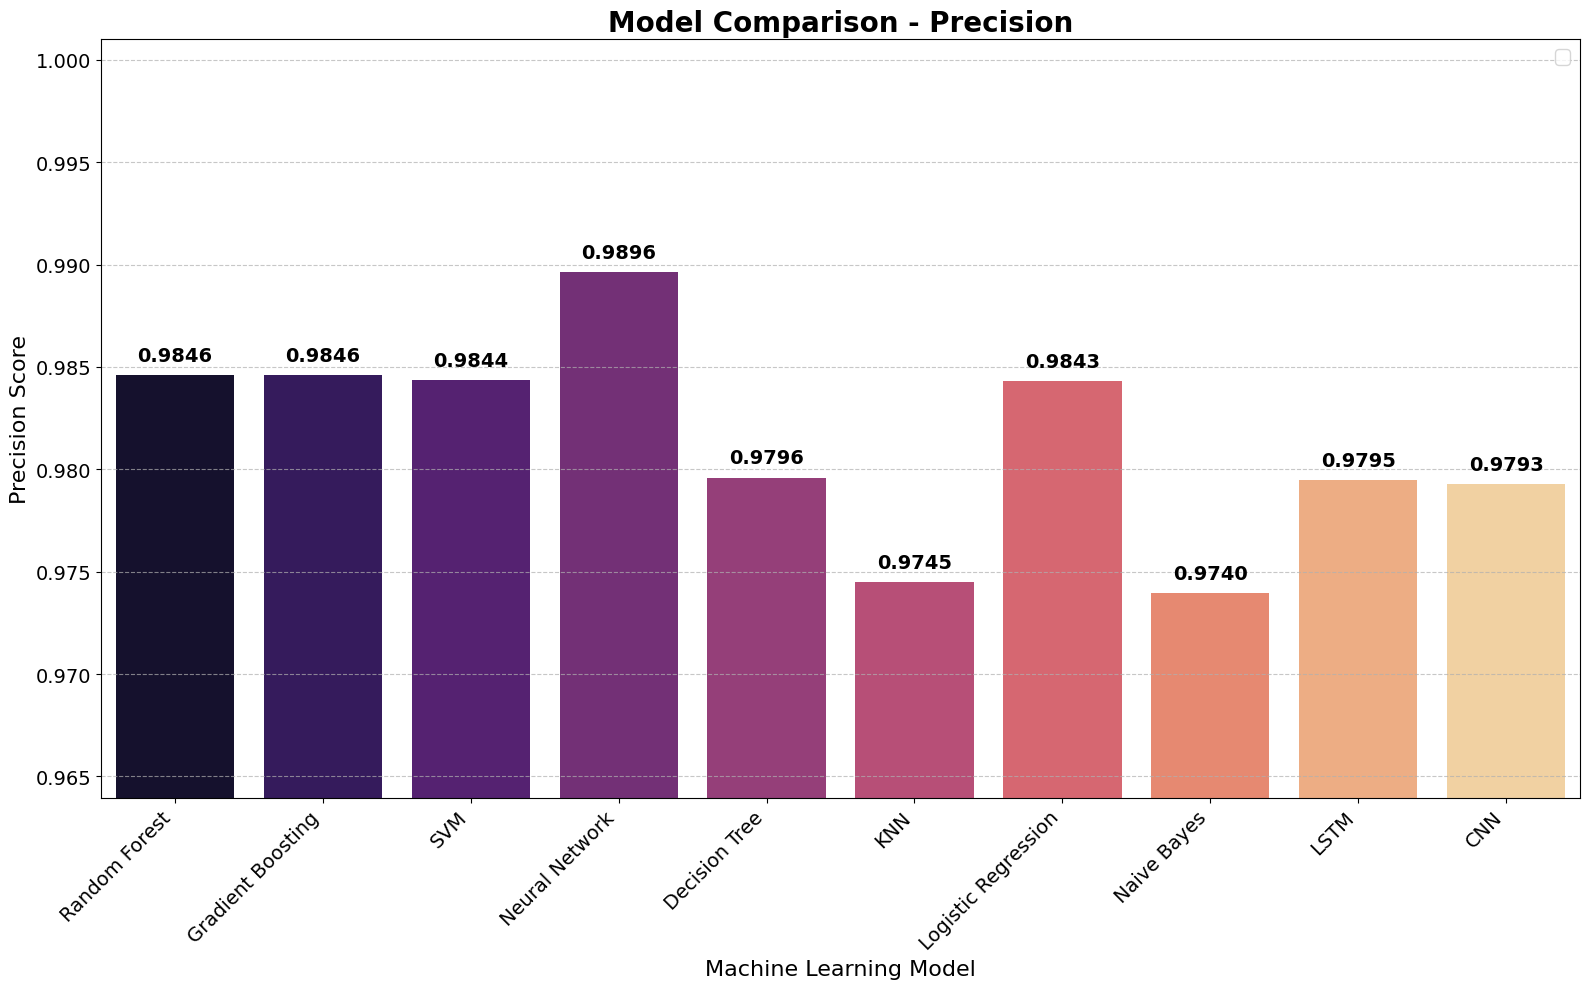

In [36]:
# Precision Comparison Visualization
plt.figure(figsize=(16, 10))

# Set a different color palette for this metric
colors = sns.color_palette("magma", len(model_names))

# Plot with enhanced styling
ax = sns.barplot(x=df_metrics.index, y=df_metrics['Precision'], palette=colors)

# Customize the plot
plt.title('Model Comparison - Precision', fontsize=20, fontweight='bold')
plt.xlabel('Machine Learning Model', fontsize=16)
plt.ylabel('Precision Score', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set y-axis limits to better visualize the differences
min_val = df_metrics['Precision'].min() - 0.01 if df_metrics['Precision'].min() < 0.99 else 0.99
plt.ylim(min_val, 1.001)

# Add value labels on top of each bar
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(f"{height:.4f}", 
                (p.get_x() + p.get_width() / 2., height + 0.0005), 
                ha='center', va='bottom', 
                fontsize=14, fontweight='bold',
                color='white' if colors[i] in sns.dark_palette("purple") else 'black')
    
# Add a horizontal line at the average precision
# avg_precision = df_metrics['Precision'].mean()
# plt.axhline(y=avg_precision, color='r', linestyle='--', alpha=0.7, 
#             label=f'Average Precision: {avg_precision:.4f}')
plt.legend(fontsize=14)

plt.tight_layout()
plt.savefig('precision_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\agyem\AppData\Local\Temp\ipykernel_10212\1754659458.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_metrics.index, y=df_metrics['Recall'], palette=colors)
C:\Users\agyem\AppData\Local\Temp\ipykernel_10212\1754659458.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


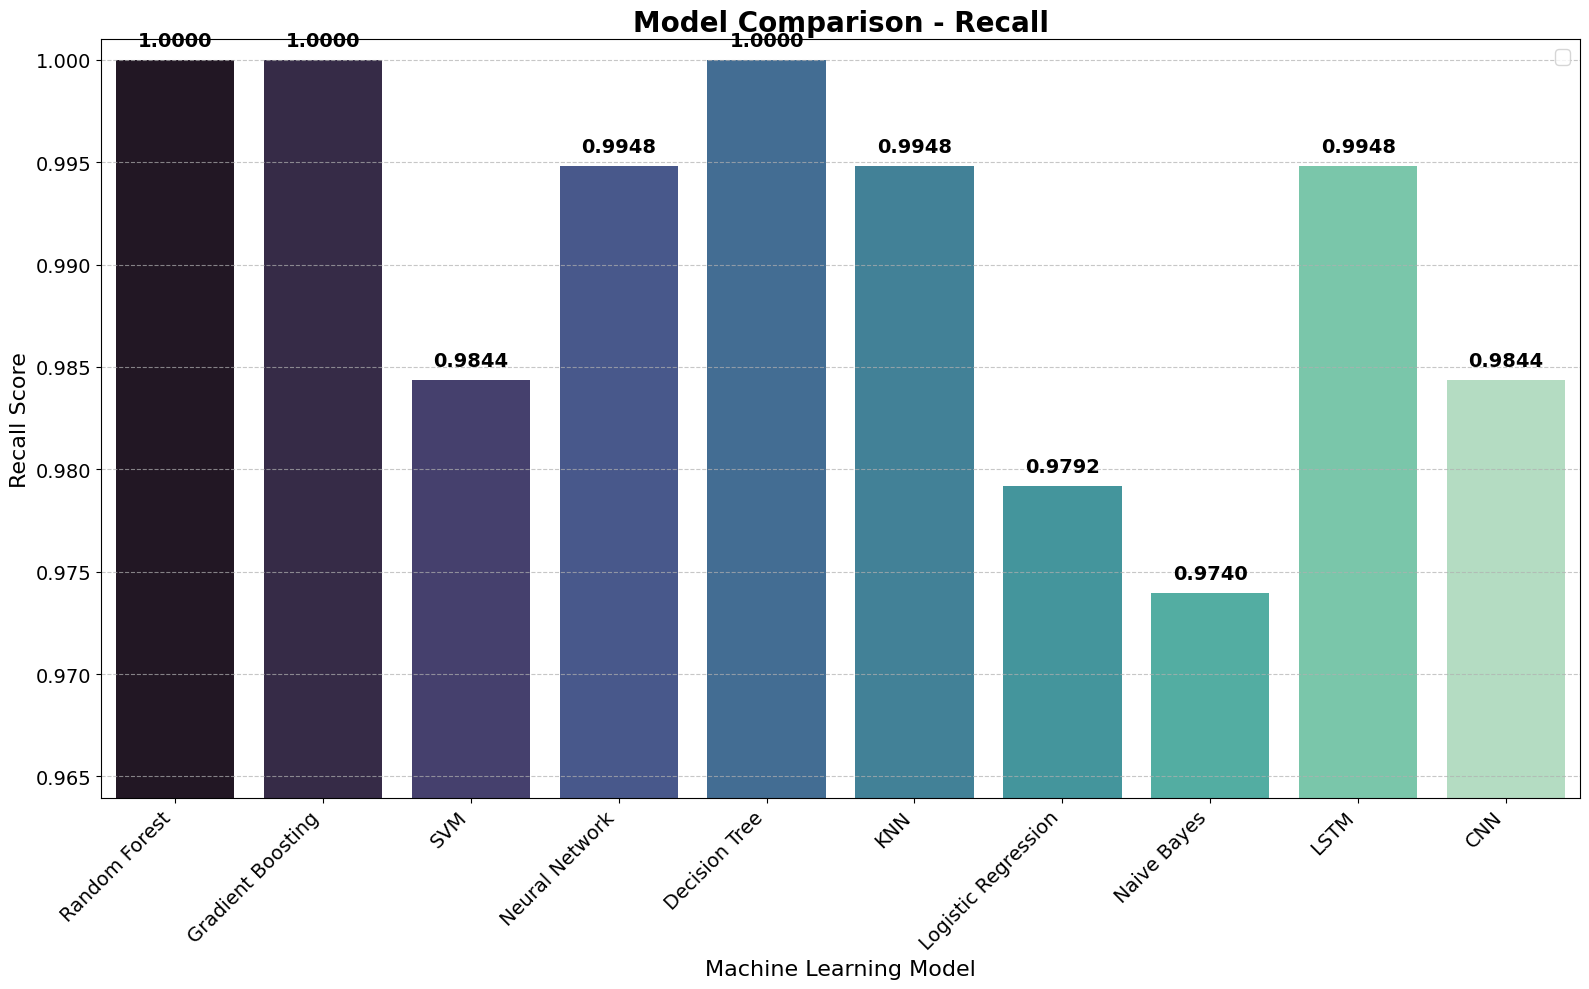

In [38]:
# Recall Comparison Visualization
plt.figure(figsize=(16, 10))

# Set a different color palette for this metric
colors = sns.color_palette("mako", len(model_names))

# Plot with enhanced styling
ax = sns.barplot(x=df_metrics.index, y=df_metrics['Recall'], palette=colors)

# Customize the plot
plt.title('Model Comparison - Recall', fontsize=20, fontweight='bold')
plt.xlabel('Machine Learning Model', fontsize=16)
plt.ylabel('Recall Score', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set y-axis limits to better visualize the differences
min_val = df_metrics['Recall'].min() - 0.01 if df_metrics['Recall'].min() < 0.99 else 0.99
plt.ylim(min_val, 1.001)

# Add value labels on top of each bar
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(f"{height:.4f}", 
                (p.get_x() + p.get_width() / 2., height + 0.0005), 
                ha='center', va='bottom', 
                fontsize=14, fontweight='bold')
    
# Add a horizontal line at the average recall
# avg_recall = df_metrics['Recall'].mean()
# plt.axhline(y=avg_recall, color='r', linestyle='--', alpha=0.7, 
#             label=f'Average Recall: {avg_recall:.4f}')
plt.legend(fontsize=14)

plt.tight_layout()
plt.savefig('recall_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\agyem\AppData\Local\Temp\ipykernel_10212\3156566459.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=df_metrics.index, y=df_metrics['F1-score'], palette=colors)
C:\Users\agyem\AppData\Local\Temp\ipykernel_10212\3156566459.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


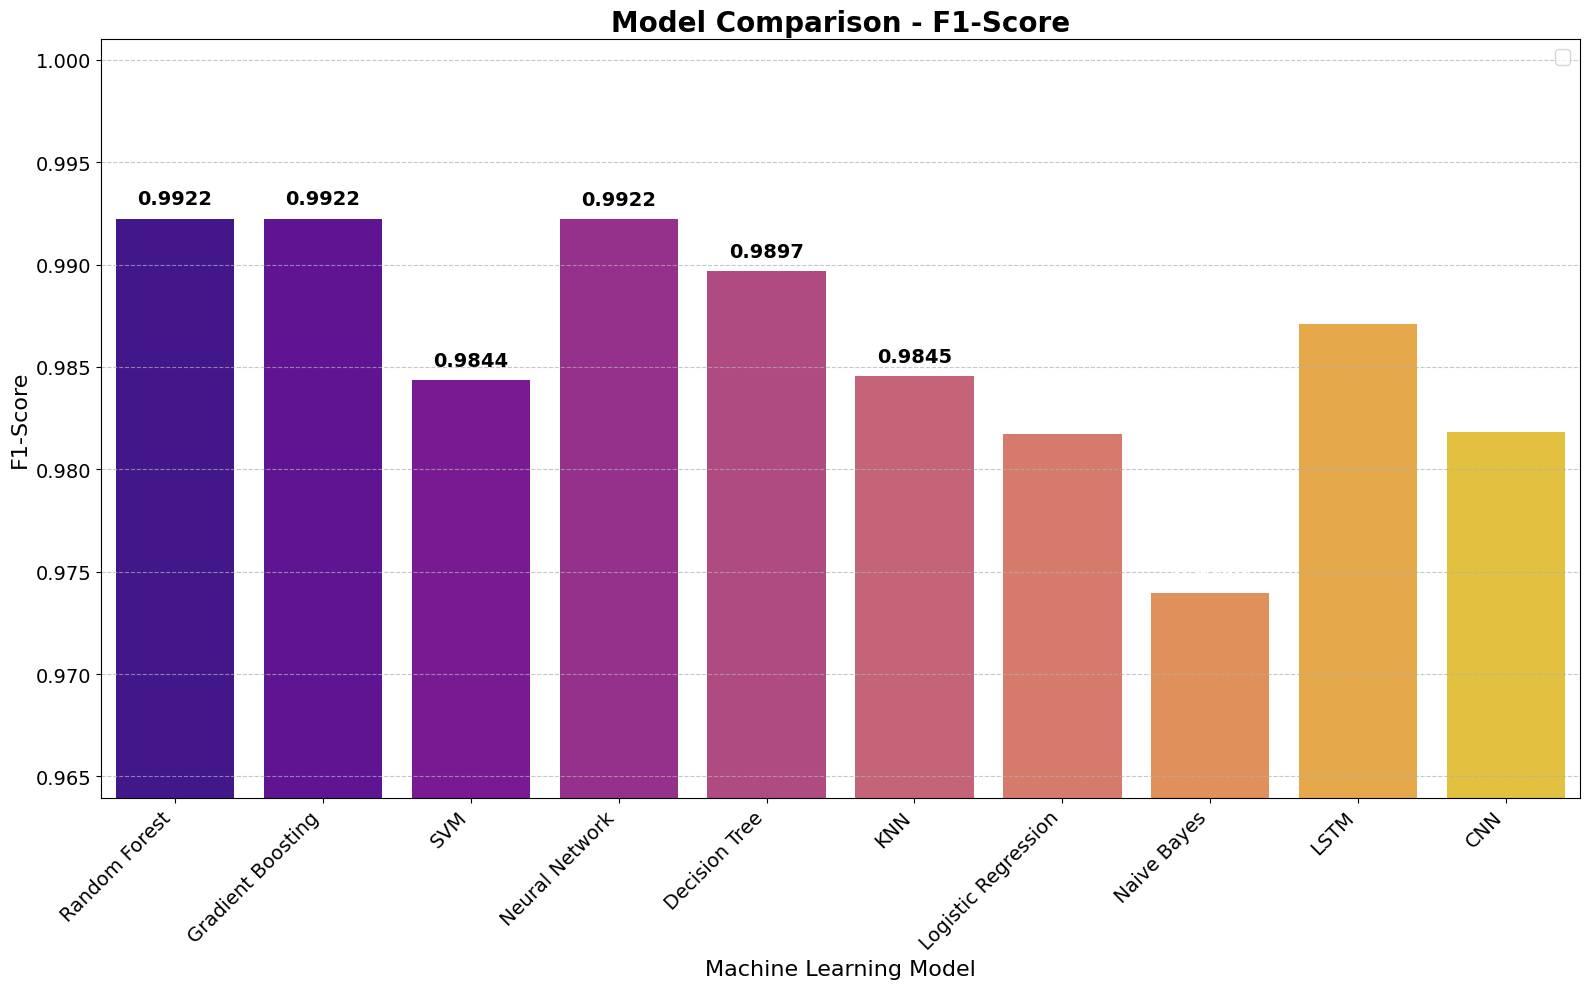

In [40]:
# F1-Score Comparison Visualization
plt.figure(figsize=(16, 10))

# Set a different color palette for this metric
colors = sns.color_palette("plasma", len(model_names))

# Plot with enhanced styling
ax = sns.barplot(x=df_metrics.index, y=df_metrics['F1-score'], palette=colors)

# Customize the plot
plt.title('Model Comparison - F1-Score', fontsize=20, fontweight='bold')
plt.xlabel('Machine Learning Model', fontsize=16)
plt.ylabel('F1-Score', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set y-axis limits to better visualize the differences
min_val = df_metrics['F1-score'].min() - 0.01 if df_metrics['F1-score'].min() < 0.99 else 0.99
plt.ylim(min_val, 1.001)

# Add value labels on top of each bar
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(f"{height:.4f}", 
                (p.get_x() + p.get_width() / 2., height + 0.0005), 
                ha='center', va='bottom', 
                fontsize=14, fontweight='bold',
                color='white' if i > len(model_names)//2 else 'black')
    
# Add a horizontal line at the average F1-score
# avg_f1 = df_metrics['F1-score'].mean()
# plt.axhline(y=avg_f1, color='r', linestyle='--', alpha=0.7, 
#             label=f'Average F1-Score: {avg_f1:.4f}')
plt.legend(fontsize=14)

plt.tight_layout()
plt.savefig('f1_score_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Enhanced Comparison - Training Time and ROC Curves

import time
from sklearn.metrics import roc_curve, roc_auc_score

# Create a new figure for ROC curves
plt.figure(figsize=(15, 10))

# Define a list of models to evaluate
models_to_evaluate = [
    ('Random Forest', rf),
    ('Gradient Boosting', gb),
    ('SVM', svm),
    ('Decision Tree', dt),
    ('KNN', knn),
    ('Logistic Regression', lr),
    ('Naive Bayes', nb)
]

# Empty lists to store results
model_names = []
roc_auc_scores = []
training_times = []

# For each model, compute ROC curve and AUC
for name, model in models_to_evaluate:
    model_names.append(name)
    
    # Measure training time (re-fit the model)
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)
    
    # For ROC curve, we need probability estimates
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        roc_auc_scores.append(auc)
        
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
    except:
        print(f"Warning: {name} doesn't support predict_proba. Skipping ROC curve.")
        roc_auc_scores.append(None)

# Plot ROC curves
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('roc_curves.png')
plt.show()

# Plot training times
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names[:len(training_times)], training_times)
plt.title('Model Training Time Comparison')
plt.ylabel('Training Time (seconds)')
plt.xticks(rotation=45, ha='right')

# Add time values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}s',
             ha='center', va='bottom')

plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.savefig('training_times.png')
plt.show()